In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from PIL import Image, ImageOps
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim
%matplotlib inline

#### Load image and convert it into grayscale

In [3]:
img = Image.open("./samples/dogs02.jpg")
img = ImageOps.grayscale(img)
img = np.asarray(img, dtype=np.float32)
img = img.copy() #img.setflags(write=1) is not working but copying works!
org_img = img.copy()

In [4]:
class PCA_data_compress:
    
    def __init__(self, data_mat, is_subtract_mean=True):
        """ Implementation of Princial Component Analysis technique 
            :param data_mat: data matrix which is assumed to be of 'num_samples x num_feats' format 
            :param is_subtract_mean: whether to remove mean from each feature 
        """
        self.is_subtract_mean = is_subtract_mean
        if self.is_subtract_mean:
            # save the mean values since it is going to used later for reconstruction
            print("subtracting mean from data matrix...")
            self.data_mat_means = data_mat.mean(axis=0)
            data_mat -= self.data_mat_means
        self.data_mat = data_mat.T
        print(f"shape of the data matrix (num_feats x num_samples) {self.data_mat.shape}")
        
    def compute_cov(self, is_plot_cov=True):
        """ Compute covariance matrix of a data matrix 
            :param is_plot_cov: whether to plot covariance matrix
        """
        print("computing covariance matrix...")
        self.cov_mat = np.cov(self.data_mat)
        
        if is_plot_cov:
            self._plot_cov(self.cov_mat)
            
    def _plot_cov(self, cov_mat):
        """ Plot covariance matrix """
        print(f"plotting covariance matrix with dim: {cov_mat.shape}...")
        plt.imshow(cov_mat)
        plt.title("Covariance matrix")
        plt.colorbar()
        plt.show()
            
    def _sort_eigen_descend(self, eigen_vals, eigen_vecs):
        """ Sort eigenvalue and eigenvetor matrices according to eigenvalues in a descending order """ 
        print("sorting eigenvalue and eigenvector according to eigenvalues in a descending order...")
        # get the indices in descending order from eigen values
        inds_descend = np.flip(np.argsort(eigen_vals))
        
        # in the same order, sort eigen values and eigen vectors
        eigen_vals = eigen_vals[inds_descend]
        eigen_vecs = eigen_vecs[:, inds_descend] 
        
        return eigen_vals, eigen_vecs

    def compute_eigen(self):
        """ Computes eigenvalues and eigenvectors of a covariance matrix and sort them 
            according to the eigenvalues in a descending order 
        """
        print("computing eigenvalues and eigenvectors of a covariance matrix...")
        # compute eigenvalues and eigenvectors
        eigen_vals, eigen_vecs = np.linalg.eig(self.cov_mat)
        
        # sort both according to eigen values in a descending order 
        self.eigen_vals, self.eigen_vecs = self._sort_eigen_descend(eigen_vals, eigen_vecs)
        
        # plot eigenvalues (explained variances) in a descending and cumulative plot     
        tot_val = sum(self.eigen_vals)
        var_vals = [(var_val/tot_val) for var_val in self.eigen_vals]
        cum_var_vals = np.cumsum(var_vals)

        plt.figure(figsize=(10, 7))
        plt.bar(range(1, self.cov_mat.shape[0]+1), var_vals, alpha=0.5, 
                label='explained variance of each component')
        plt.step(range(1, self.cov_mat.shape[0]+1), cum_var_vals, 
                 label='explained variance of each component')

        plt.title("variance explained by components")
        plt.xlabel("principal components")
        plt.ylabel("explained variance")
        plt.xlim(0, self.cov_mat.shape[0])
        plt.ylim(0, 1)
        plt.legend(loc='upper left')
        plt.grid(linestyle='--')
        plt.show()
            
    def compute_proj_data_mat(self, num_comps, is_plot_cov=True):
        """ Compute projected data matrix using the number of components 
            :param num_comps: number of highest eigenvectors to keep 
            :param is_plot_cov: whether to plot covariance matrix of the projected data matrix 
        """
        if num_comps > self.cov_mat.shape[0]:
            print(f"max number of components possible is {self.cov_mat.shape[0]} and provided is {num_comps}")
            num_comps = self.cov_mat.shape[0] 
            
        print(f"computing projected data matrix acc to number of components {num_comps} to keep...")
        # project the original data matrix onto (reduced) eigen vectors 
        self.eigen_vecs_basis = self.eigen_vecs[:, :num_comps] 
        self.proj_data_mat = np.dot(self.eigen_vecs_basis.T, self.data_mat)
        
        # plot the covariance of the project data matrix. Note: it should be diagonal and each 
        # diagonal elements should be in descending order 
        if is_plot_cov:
            cov_mat = np.cov(self.proj_data_mat)
            self._plot_cov(cov_mat)
        print(f"shape of the projected data matrix: {self.proj_data_mat.shape}")
    
    def reconstruct_img(self):
        """ Reconstruct data matrix back from projected data matrix """
        print("reconstructing data matrix back from projected data matrix...")
        # reconstruct the data matrix back 
        recontruct_data_mat = np.dot(self.eigen_vecs_basis, self.proj_data_mat)
        
        recontruct_data_mat = recontruct_data_mat.T
        # add the removed means 
        if self.is_subtract_mean:
            
            recontruct_data_mat += self.data_mat_means
    
        # transpose back to num_samples x num_feats format
        print(f"shape of the reconstructed data matrix: {recontruct_data_mat.shape}")
        return np.asarray(recontruct_data_mat, dtype=np.float32)

shape of the original image: (432, 383)


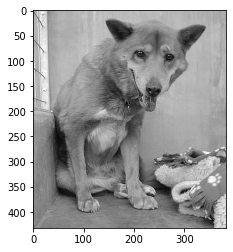

In [5]:
print(f"shape of the original image: {org_img.shape}")
plt.figure()
plt.imshow(org_img, cmap="gray")
plt.show()

In [6]:
pca = PCA_data_compress(img)

subtracting mean from data matrix...
shape of the data matrix (num_feats x num_samples) (383, 432)


computing covariance matrix...
plotting covariance matrix with dim: (383, 383)...


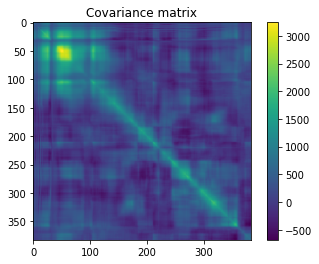

computing eigenvalues and eigenvectors of a covariance matrix...
sorting eigenvalue and eigenvector according to eigenvalues in a descending order...


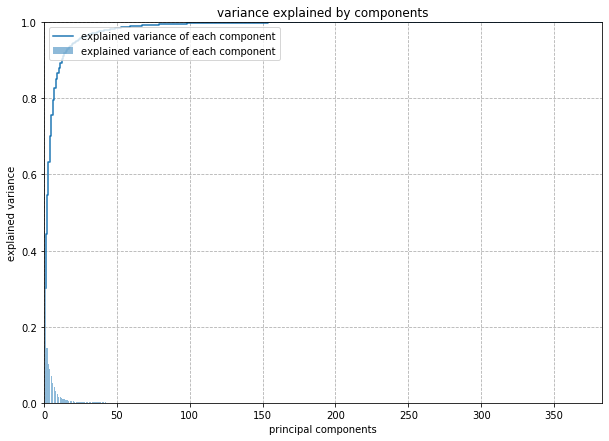

In [7]:
pca.compute_cov()

pca.compute_eigen()

##################################################
computing projected data matrix acc to number of components 10 to keep...
plotting covariance matrix with dim: (10, 10)...


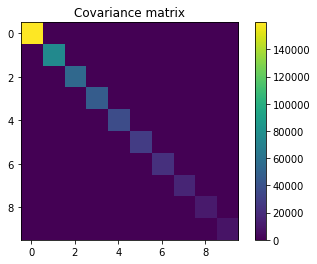

shape of the projected data matrix: (10, 432)
reconstructing data matrix back from projected data matrix...
shape of the reconstructed data matrix: (432, 383)
structured similarity index between org and reconstructed images: 0.39263455675260733


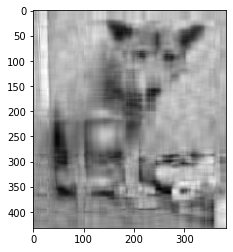

##################################################
##################################################
computing projected data matrix acc to number of components 20 to keep...
plotting covariance matrix with dim: (20, 20)...


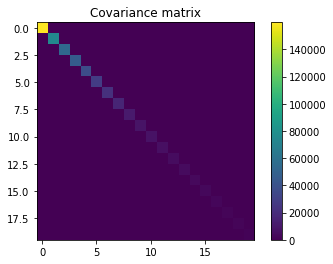

shape of the projected data matrix: (20, 432)
reconstructing data matrix back from projected data matrix...
shape of the reconstructed data matrix: (432, 383)
structured similarity index between org and reconstructed images: 0.5236065264287071


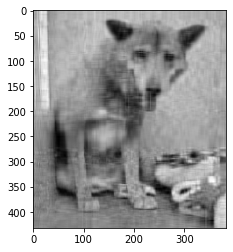

##################################################
##################################################
computing projected data matrix acc to number of components 50 to keep...
plotting covariance matrix with dim: (50, 50)...


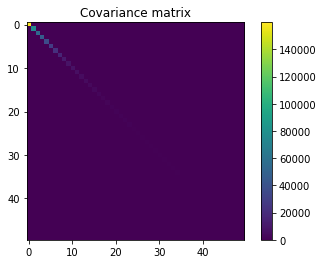

shape of the projected data matrix: (50, 432)
reconstructing data matrix back from projected data matrix...
shape of the reconstructed data matrix: (432, 383)
structured similarity index between org and reconstructed images: 0.726209628189516


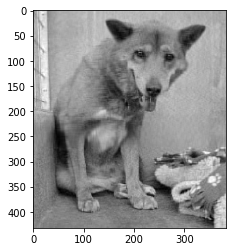

##################################################
##################################################
computing projected data matrix acc to number of components 100 to keep...
plotting covariance matrix with dim: (100, 100)...


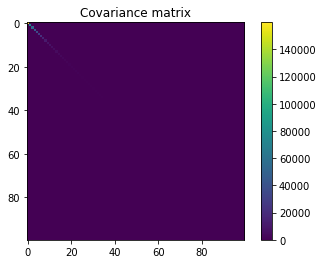

shape of the projected data matrix: (100, 432)
reconstructing data matrix back from projected data matrix...
shape of the reconstructed data matrix: (432, 383)
structured similarity index between org and reconstructed images: 0.8949200596961252


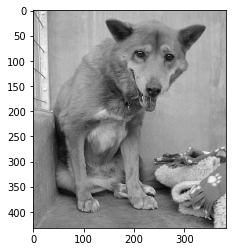

##################################################
##################################################
computing projected data matrix acc to number of components 200 to keep...
plotting covariance matrix with dim: (200, 200)...


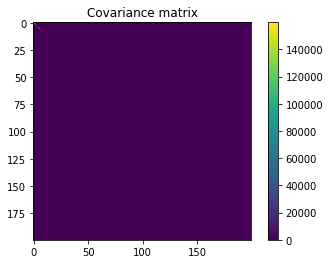

shape of the projected data matrix: (200, 432)
reconstructing data matrix back from projected data matrix...
shape of the reconstructed data matrix: (432, 383)
structured similarity index between org and reconstructed images: 0.9903379676990789


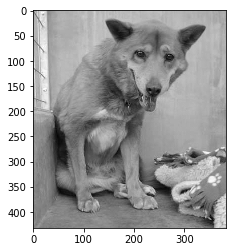

##################################################


In [8]:
for ncomp in [10, 20, 50, 100, 200]:
    print("#"*50)
    pca.compute_proj_data_mat(ncomp)
    reconstruct_img = pca.reconstruct_img()
    
    print(f"structured similarity index between org and reconstructed images: {ssim(org_img, reconstruct_img)}")
    
    plt.figure()
    plt.imshow(reconstruct_img, cmap="gray")
    plt.show()
    print("#"*50)
    